# This notebook presents a baseline cnn model trained with and without data augmentation to see the differences



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Jeremynadal33/classify_stanford_dogs/blob/master/baseline.ipynb)

First, import the relevant libraries : 
First, we will try this with only 4 different classes and import the relevant librairies

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
import os 
import shutil
import matplotlib.pyplot as plt 
from matplotlib import image
import numpy as np
from sklearn.model_selection import train_test_split

print(tf.__version__)

2.4.1


In [2]:
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  from google.colab import drive
  drive.mount('/content/gdrive',force_remount=True)
  !ls /content/gdrive/My\ Drive/Formation-OC/P5-Stackoverflow
  root_dir = '/content/gdrive/My Drive/Formation-OC/P6-Images/'
  input_dir = root_dir + 'inputs/'
  png_dir = root_dir + 'pngs/'

  baseline_species = os.listdir(input_dir+'baseline_inputs/train')

  #my script
  !ls gdrive/MyDrive/Formation-OC/P6-Images/
else:
  print('Not running on CoLab')
  #my script
  root_dir = '/Users/jeremynadal/Documents/Formation OC IML/P6/'
  input_dir = root_dir + 'inputs/'
  png_dir = root_dir + 'pngs/'
  model_dir = root_dir +'models/'

Running on CoLab
Mounted at /content/gdrive
function.py  inputs  P5_presentation.pptx  pngs
inputs	models	P6-presentation.pptx  pngs


In [ ]:
species = os.listdir(input_dir+'Images/')
species = [specie for specie in species if specie !='.DS_Store']
print('There are {} different species'.format(len(species)))

There are 120 different species


## Lets create a repertory called baseline_inputs to get only 4 different races :

In [12]:
def create_baseline_train_val_rep(species, input_dir, validation_split=0.3, random_seed = 42 ):
    '''Create repertories and put train and validation into them. Careful, the images must already be in separate folders into an Image rep.
    input_dir (str): the path where to create the baseline directory
    species (list(str)): the list of directories to take and split into train and validation
    validation split (float, optional): proportion of img to take as validation. Default is 0.3.'''
    
    assert os.path.exists(input_dir), 'input_dir doesnot exists'
    img_dir = input_dir+'Images/'
    baseline_dir = input_dir+'baseline_inputs/'
    
    assert os.path.exists(img_dir), 'every images must be into a Images directory in the input_dir'
    for specie in species :
        assert os.path.exists(img_dir+specie), '{} folder doesnot exists'.format(specie)
    
    assert not os.path.exists(baseline_dir), 'baseline_inputs already exists, consider removing it first'
    
    np.random.seed(random_seed)
    os.mkdir(baseline_dir)
    os.mkdir(baseline_dir+'train')
    os.mkdir(baseline_dir+'validation')
    for specie in species:
        os.mkdir(baseline_dir+'train/'+specie)
        os.mkdir(baseline_dir+'validation/'+specie)
        
        img_names = os.listdir(img_dir+specie)
        img_train, img_validation = train_test_split(img_names, test_size=validation_split, random_state=random_seed)
      
        print('For class {}, there is {} training images and {} validation images'.format(specie.split('-')[1],len(img_train),len(img_validation)))
        for img in img_train :
            shutil.copy(img_dir+specie+'/'+img, baseline_dir+'train/'+specie )
        for img in img_validation :
            shutil.copy(img_dir+specie+'/'+img, baseline_dir+'validation/'+specie )

In [3]:
np.random.seed(42) # To ensure re-usability
baseline_dir = input_dir+'baseline_inputs/'
baseline_species = np.random.choice(species,4)
baseline_dir = input_dir+'baseline_inputs/'
print(baseline_species)

NameError: ignored

In [ ]:
if os.path.exists(baseline_dir):
    print('baseline_inputs exists, removing it')
    shutil.rmtree(baseline_dir)
    create_baseline_train_val_rep(baseline_species, input_dir, validation_split=0.2, random_seed = 42 )
else :
    print('baseline_inputs doesnot exists')
    create_baseline_train_val_rep(baseline_species, input_dir, validation_split=0.2, random_seed = 42 )


baseline_inputs exists, removing it
For class toy_poodle, there is 120 training images and 31 validation images
For class miniature_poodle, there is 124 training images and 31 validation images
For class Great_Dane, there is 124 training images and 32 validation images
For class English_foxhound, there is 125 training images and 32 validation images


### Lets display the _idx_ img of each specie

NameError: ignored

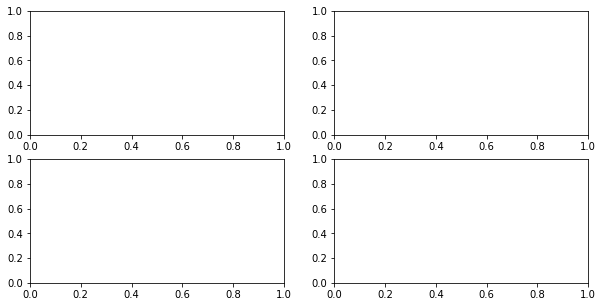

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(10, 5), sharex=False)

axes = axes.flatten()
for idx in range(len(baseline_species)):
    img = image.imread(baseline_dir+'train/'+baseline_species[idx]+'/'+os.listdir(baseline_dir+'train/'+baseline_species[idx])[0])
    axes[idx].imshow(img)
    #axes[idx].imshow()
    axes[idx].set_title(baseline_species[idx].split('-')[1])
    axes[idx].axis('off')

plt.show()

## Now lets instanciate an image augmentation object from tf.keras to understand its behavior

In [4]:
def display_aug(generator, img_path, target_size = (150,150), nb_img=4):
    assert nb_img < 7, 'please keep nb_img under 7'
    assert len(target_size)==2, 'Target size must be of (height, length)'

    img = load_img(img_path, grayscale=False, target_size=target_size)
    x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
    x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
    
    fig, axes = plt.subplots(1, nb_img, figsize=(int(3*nb_img),int(5*nb_img)), sharex=False)

    axes = axes.flatten()

    idx = 0
    for batch in generator.flow(x, batch_size=1):
        axes[idx].imshow(array_to_img(batch[0]))
        axes[idx].axis('off')
        idx += 1
        if idx > nb_img-1:
            break
    plt.show()

## Lets build two imagedatagenerator : one will be used for data augmentation later and the other which doesnot do data augmentation. 
## The latter will be used for both training and validation to create a baseline model

In [5]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip = True,
                                   fill_mode='nearest')

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)


Using the augmentation


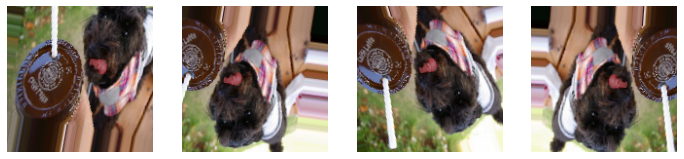

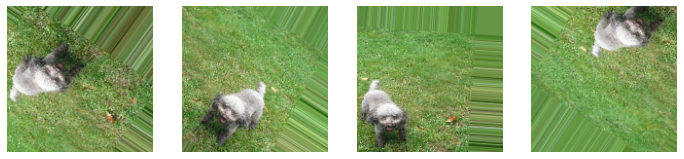

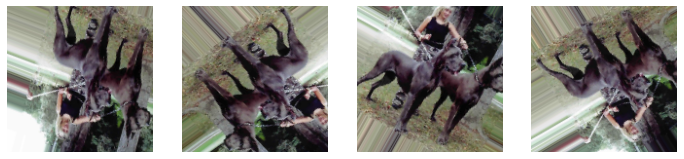

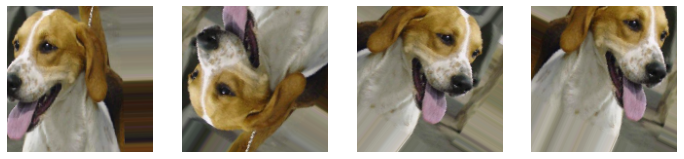

Using the no augmentation 


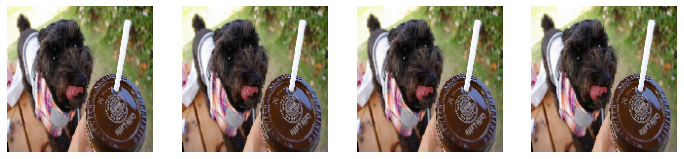

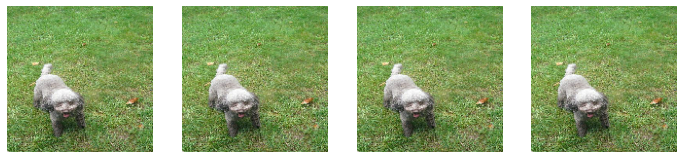

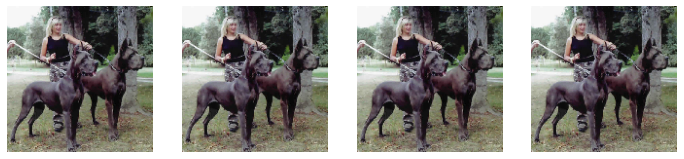

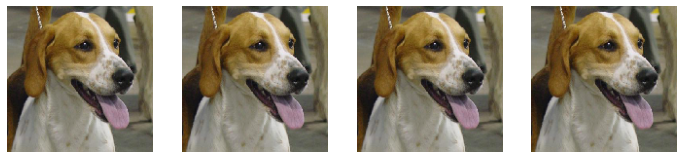

In [6]:
idx = 0
print('Using the augmentation')
for specie in baseline_species:
    display_aug(train_datagen, baseline_dir+'train/'+specie+'/'+os.listdir(baseline_dir+'train/'+specie)[idx])
    
print('Using the no augmentation ')
for specie in baseline_species:
    display_aug(test_datagen, baseline_dir+'train/'+specie+'/'+os.listdir(baseline_dir+'train/'+specie)[idx])
    

## Make a new directory to train and put specificaly augmented data
First, lets define each function to modify the images. Here, we will :
* Flip horizontally 
* Flip vertically 
* Horizontal shift
* Vertical shift
* Rotates the images
* Zoom 
* Modify brightness

In [201]:
import cv2 as cv2
import random
from google.colab.patches import cv2_imshow

def fill(img, h, w):
    img = cv2.resize(img, (h, w), cv2.BORDER_REPLICATE)
    return img


def shift(img, horizontal = False, vertical = False, ratio=0.0):
  
  assert not (ratio<-1) or (ratio>1), 'ratio must be between -1 and 1'
  assert ((horizontal) or (vertical)) and not ((horizontal) and (vertical)), 'Either horizontal or vertical must be True'
  
  #ratio = random.uniform(-ratio, ratio)
  h, w = img.shape[:2]

  if horizontal : 
    to_shift = w*ratio
    if ratio > 0:
      img = img[:, :int(w-to_shift), :]
    if ratio < 0:
      img = img[:, int(-1*to_shift):, :]
  elif vertical : 
    to_shift = h*ratio
    if ratio > 0:
        img = img[:int(h-to_shift), :, :]
    if ratio < 0:
        img = img[int(-1*to_shift):, :, :]
  
  img = fill(img, h, w)
  return img


def flip(img, vertical = False, horizontal = False ):
  assert ((horizontal) or (vertical)) and not ((horizontal) and (vertical)), 'Either horizontal or vertical must be True'

  if horizontal : 
    img = cv2.flip(img, 1)
  elif vertical : img = cv2.flip(img, 0)

  return img


def rotation(img, angle):
    #angle = int(random.uniform(-angle, angle))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))

    img = fill(img, h, w)
    return img


def zoom(img, value):
    assert not (value<0) or (value>1), 'value must be between -1 and 1'

    if value <= 1 : 
      h, w = img.shape[:2]
      h_taken = int(value*h)
      w_taken = int(value*w)
      h_start = random.randint(0, h-h_taken)
      w_start = random.randint(0, w-w_taken)
      img = img[h_start:h_start+h_taken, w_start:w_start+w_taken, :]
      img = fill(img, h, w)
    if value > 1 : 
      h, w = img.shape[:2]
      new_h = int(value*h)
      new_w = int(value*w)
      h_start = new_h - int((h+new_h)/2)
      w_start = new_w - int((w+new_w)/2)

      new_img = np.zeros((new_h, new_w,3),dtype=int)

      new_img[h_start:h_start+h, w_start:w_start+w, :] = img 

      img = new_img

    return img

def brightness(img, low=1, high=3):
    value = random.uniform(low, high)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype = np.float64)
    hsv[:,:,1] = hsv[:,:,1]*value
    hsv[:,:,1][hsv[:,:,1]>255]  = 255
    hsv[:,:,2] = hsv[:,:,2]*value 
    hsv[:,:,2][hsv[:,:,2]>255]  = 255
    hsv = np.array(hsv, dtype = np.uint8)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img

def histogram_equalization(img_in):
  # segregate color streams
  b,g,r = cv2.split(img_in)
  h_b, bin_b = np.histogram(b.flatten(), 256, [0, 256])
  h_g, bin_g = np.histogram(g.flatten(), 256, [0, 256])
  h_r, bin_r = np.histogram(r.flatten(), 256, [0, 256])
  # calculate cdf    
  cdf_b = np.cumsum(h_b)  
  cdf_g = np.cumsum(h_g)
  cdf_r = np.cumsum(h_r)
    
  # mask all pixels with value=0 and replace it with mean of the pixel values 
  cdf_m_b = np.ma.masked_equal(cdf_b,0)
  cdf_m_b = (cdf_m_b - cdf_m_b.min())*255/(cdf_m_b.max()-cdf_m_b.min())
  cdf_final_b = np.ma.filled(cdf_m_b,0).astype('uint8')
  
  cdf_m_g = np.ma.masked_equal(cdf_g,0)
  cdf_m_g = (cdf_m_g - cdf_m_g.min())*255/(cdf_m_g.max()-cdf_m_g.min())
  cdf_final_g = np.ma.filled(cdf_m_g,0).astype('uint8')
  cdf_m_r = np.ma.masked_equal(cdf_r,0)
  cdf_m_r = (cdf_m_r - cdf_m_r.min())*255/(cdf_m_r.max()-cdf_m_r.min())
  cdf_final_r = np.ma.filled(cdf_m_r,0).astype('uint8')
  # merge the images in the three channels
  img_b = cdf_final_b[b]
  img_g = cdf_final_g[g]
  img_r = cdf_final_r[r]
  
  img_out = cv2.merge((img_b, img_g, img_r))
  # validation
  equ_b = cv2.equalizeHist(b)
  equ_g = cv2.equalizeHist(g)
  equ_r = cv2.equalizeHist(r)
  equ = cv2.merge((equ_b, equ_g, equ_r))
  
  return img_out


def handmade_augmentation(input_dir, output_dir):
  assert os.path.exists(input_dir), 'input_dir doesnot exist'
  assert os.path.exists(output_dir), 'output_dir doesnot exist, please create it first'
  
  if output_dir[-1]!='/': output_dir+'/'
  if input_dir[-1]!='/': input_dir+'/'

  species = os.listdir(input_dir) 

  assert os.path.isdir(input_dir+species[0]), 'input_dir must contain directories of images'

  
  print('Looking for images and returning 12 times as many images')
  for output_fold in os.listdir(output_dir):
    os.rmdir(output_dir+output_fold)

  for specie in species :
    os.mkdir(output_dir+specie)
    print('Dealing with ', specie.split('-')[1], '\nFound {} images'.format(len(os.listdir(input_dir+specie))))

    for file in os.listdir(input_dir+specie) :

      img = plt.imread(input_dir+specie+'/'+file)
      imgs = [img]
      imgs.append( shift(img, ratio = 0.25, horizontal= True) ) 
      imgs.append( shift(img, ratio = 0.25, vertical= True) )

      imgs.append( flip(img, horizontal= True) )
      imgs.append( flip(img, vertical= True) )

      imgs.append( rotation(img, 45) )
      imgs.append( rotation(img, -45) )
      imgs.append( rotation(img, 135) )

      imgs.append( zoom(img, 0.9) )

      imgs.append( zoom(img, 1.5) )

      imgs.append( brightness(img, 1, 3) )

      imgs.append( histogram_equalization(img) )

      for idx in range(len(imgs)) :
        name = output_dir+specie+'/aug_'+str(file).split('.')[0]+'_'+str(idx)+'.jpg'
        cv2.imwrite(name, imgs[idx])


In [170]:
img_path = baseline_dir+'train/'+os.listdir(baseline_dir+'train/')[3]+'/'+ os.listdir(baseline_dir+'train/'+os.listdir(baseline_dir+'train/')[3])[0]

img = plt.imread( img_path, 0  )

h, w = img.shape[:2]

#img = fill(img, h, w)

img_shift_h = shift(img, ratio = 0.25, horizontal= True)
img_shift_v = shift(img, ratio = 0.25, vertical= True)

img_flip_h = flip(img, horizontal= True)
img_flip_v = flip(img, vertical= True)

img_rot_1 = rotation(img, 45)
img_rot_2 = rotation(img, -45)
img_rot_3 = rotation(img, 135)

img_zoom_in = zoom(img, 0.9)

img_zoom_out = zoom(img, 1.5)

img_brightness = brightness(img, 1, 3)

img_equalized = histogram_equalization(img)



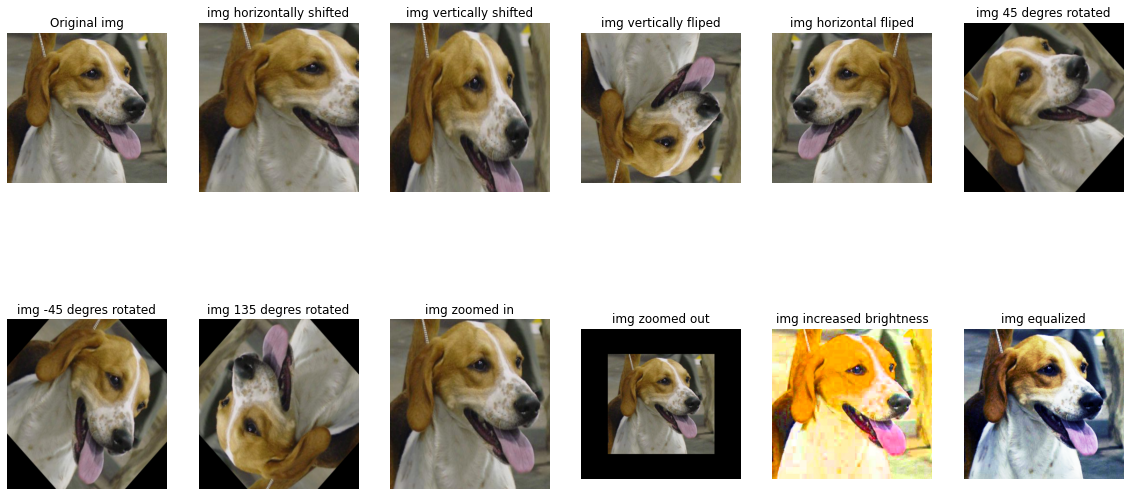

In [171]:
fig, axes = plt.subplots(2, 6, figsize=(20,10), sharex=False)

axes = axes.flatten()

axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title('Original img')

axes[1].imshow(img_shift_h)
axes[1].axis('off')
axes[1].set_title('img horizontally shifted')

axes[2].imshow(img_shift_v)
axes[2].axis('off')
axes[2].set_title('img vertically shifted')


axes[3].imshow(img_flip_v)
axes[3].axis('off')
axes[3].set_title('img vertically fliped')

axes[4].imshow(img_flip_h)
axes[4].axis('off')
axes[4].set_title('img horizontal fliped')


axes[5].imshow(img_rot_1)
axes[5].axis('off')
axes[5].set_title('img 45 degres rotated')

axes[6].imshow(img_rot_2)
axes[6].axis('off')
axes[6].set_title('img -45 degres rotated')

axes[7].imshow(img_rot_3)
axes[7].axis('off')
axes[7].set_title('img 135 degres rotated')

axes[8].imshow(img_zoom_in)
axes[8].axis('off')
axes[8].set_title('img zoomed in')

axes[9].imshow(img_zoom_out)
axes[9].axis('off')
axes[9].set_title('img zoomed out')

axes[10].imshow(img_brightness)
axes[10].axis('off')
axes[10].set_title('img increased brightness')

axes[11].imshow(img_equalized)
axes[11].axis('off')
axes[11].set_title('img equalized')

plt.savefig(root_dir+'pngs/handmade_augmentation.png')
plt.show()

In [198]:
species = os.listdir(input_dir+'baseline_inputs/train/')

In [200]:
handmade_augmentation(input_dir= input_dir+'baseline_inputs/train/', output_dir= input_dir+'baseline_inputs/train_aug/')

Looking for images and returning 12 times as many images
Dealing with  toy_poodle
Dealing with  miniature_poodle
Dealing with  Great_Dane
Dealing with  English_foxhound


In [202]:
os.listdir(input_dir+'baseline_inputs/train_aug/')

['n02113624-toy_poodle',
 'n02113712-miniature_poodle',
 'n02109047-Great_Dane',
 'n02089973-English_foxhound']

## Lets build and train the first simple CNN model

In [ ]:
# the model so far outputs 3D feature maps (height, width, features)

input_shape = (150,150,3)
batch_size = 16

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3)))


# converts our 3D feature maps to 1D feature vectors
model.add(tf.keras.layers.Flatten())  
model.add(tf.keras.layers.Dense(10,activation='relu'))
#model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(len(baseline_species),activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 80000)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 10)                800010    
_________________________________________________________________
dense_23 (Dense)             (None, 4)                 44        
Total params: 800,950
Trainable params: 800,950
Non-trainable params: 0
_________________________________________________________________


### Lets build different data generator : 
* Using train_datagen (augmentation) to apply on the fly data augmentation
* Using test_datagen (only rescaling) to do validation 
* Using test_datagen (only rescaling) to do training without any data augmentation 
* Using test_datagen (only rescaling) to do training from augmented train dataset

In [7]:
# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data

input_shape = (150,150,3)

train_generator = train_datagen.flow_from_directory(baseline_dir+'train/',  # this is the target directory
                                                   target_size=input_shape[:-1],  # all images will be resized to 150x150
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   color_mode='rgb',
                                                   seed= 42)  #useless for the no augmentation 

train_generator_no_aug = test_datagen.flow_from_directory(baseline_dir+'train/',  # this is the target directory
                                                   target_size=input_shape[:-1],  # all images will be resized to 150x150
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   color_mode='rgb',
                                                   seed= 42)  #useless for the no augmentation 



# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(baseline_dir+'validation/',
                                                        target_size=input_shape[:-1],
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                        seed= 42)


STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

Found 493 images belonging to 4 classes.
Found 493 images belonging to 4 classes.
Found 126 images belonging to 4 classes.


In [8]:
def get_callbacks(monitor='val_loss',save_name=None,patience=8):
    '''Returns the wanted callbacks to save models and avoid overfitting.
    monitor (str, optional): the monitor to check for the early stopping. Default is 'val_loss'
    save_name (str, optional): if not None, uses modelcheckpoint and saves checkpoints at the save_name. Default is None.
    patience (int, optional): number of epoch to wait for improvment of monitor. Default is 8.'''
    if save_name :
        return [tf.keras.callbacks.ModelCheckpoint(filepath=save_name,
                                                   monitor=monitor, 
                                                   save_best_only=True,
                                                   verbose=0),
                tf.keras.callbacks.EarlyStopping(monitor=monitor, 
                                                 patience=patience,
                                                 restore_best_weights=True)
                ]
    else:
        return [tf.keras.callbacks.EarlyStopping(monitor=monitor, 
                                                 patience=patience,
                                                 restore_best_weights=True)
                ]


In [ ]:
H = model.fit_generator(generator=train_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=validation_generator,
                        validation_steps=STEP_SIZE_VALID,
                        epochs=5,
                        callbacks=get_callbacks()
                        )

Epoch 1/5
30/30 [==============================] - 31s 1s/step - loss: 1.3856 - accuracy: 0.2516 - val_loss: 1.3861 - val_accuracy: 0.2589
Epoch 2/5
30/30 [==============================] - 31s 1s/step - loss: 1.3661 - accuracy: 0.3208 - val_loss: 1.3448 - val_accuracy: 0.3393
Epoch 3/5
30/30 [==============================] - 39s 1s/step - loss: 1.3608 - accuracy: 0.2917 - val_loss: 1.3862 - val_accuracy: 0.2589
Epoch 4/5
30/30 [==============================] - 43s 1s/step - loss: 1.3860 - accuracy: 0.2321 - val_loss: 1.3862 - val_accuracy: 0.2321
Epoch 5/5
30/30 [==============================] - 31s 1s/step - loss: 1.3861 - accuracy: 0.2453 - val_loss: 1.3862 - val_accuracy: 0.2589


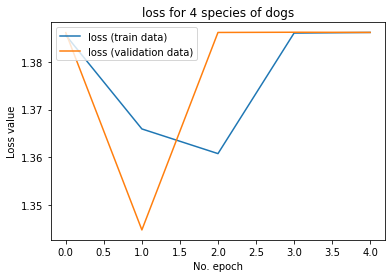

In [ ]:
plt.plot(H.history['loss'], label='loss (train data)')
plt.plot(H.history['val_loss'], label='loss (validation data)')
plt.title('loss for 4 species of dogs')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
# predictions = [labels[k] for k in predicted_class_indices]

In [9]:
def create_cnn(input_shape, output_length,
               nb_cnn=3, nb_filters = 64, activation_cnn = 'relu', 
               model_transfert = None, fine_tune = False, 
               nb_FC_layer = 3, nb_FC_neurons = 512, reducing = False, activation_FC = 'relu',
               dropout = False,
               name = 'my_cnn_model'
               ):
  '''Create a CNN based model is model_transfert is None. Else, the model_transfert is used for feature extraction. 
  If reducing is not False, nb_FC_neurons must be multiple of 2**nb_FC_layer '''

  assert input_shape[-1] == 3, 'For the moment only models with rgb input is dealt'
  #for shape in input_shape[:-1] : assert shape % 2**nb_cnn ==  0 , 'Each dimension of input must be a multiple of 2**nb_cnn'
  if reducing : assert nb_FC_neurons % 2**nb_FC_layer == 0 , 'If reducing, nb_FC_neurons must be multiple of 2**nb_FC_layer '

  model = tf.keras.models.Sequential(name=name)
  model.add(tf.keras.layers.InputLayer(input_shape=input_shape, name = 'Input_layer'))

  if model_transfert == None: 
    for cnn in range(nb_cnn):
      model.add(tf.keras.layers.Conv2D( filters = nb_filters, kernel_size = (3,3), padding='same', activation = activation_cnn, name ='Conv2D_'+str(cnn+1) ))
      model.add(tf.keras.layers.MaxPooling2D( pool_size=(2, 2), name ='MaxPool_'+str(cnn+1)))
  else : 
    if not fine_tune :
      model_transfert.trainable = False
    model.add(model_transfert)
  
  model.add(tf.keras.layers.Flatten())

  if reducing : 
    for FC in range(nb_FC_layer):
      model.add(tf.keras.layers.Dense(nb_FC_neurons/2**FC, activation= activation_FC, name='FC_layer_'+str(FC+1)))
      if dropout : 
        model.add(tf.keras.layers.Droupout(dropout, name = 'Dropout_'+str(FC+1)))
  else:
    for FC in range(nb_FC_layer):
      model.add(tf.keras.layers.Dense(nb_FC_neurons, activation= activation_FC, name='FC_layer_'+str(FC+1)))
      if dropout : 
        model.add(tf.keras.layers.Droupout(dropout, name = 'Dropout_'+str(FC+1)))

  model.add(tf.keras.layers.Dense(output_length, activation = 'softmax'))

  return model

In [14]:
input_shape = (150,150, 3)
batch_size = 16

model = create_cnn(input_shape=input_shape, output_length=len(baseline_species),
                   nb_cnn=3, nb_filters = 64, activation_cnn = 'relu', 
                   model_transfert = None, fine_tune = False, 
                   nb_FC_layer = 3, nb_FC_neurons = 512, reducing = True, activation_FC = 'relu',
                   dropout = False,
                   name = 'my_cnn_model'
                   )
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "my_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 150, 150, 64)      1792      
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 75, 75, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 37, 37, 64)        0         
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 37, 37, 64)        36928     
_________________________________________________________________
MaxPool_3 (MaxPooling2D)     (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 20736)            

### Everything is ready, lets compare models training with and without data augmentation : 
* Using no data augmentation
* Using on the fly data augmentation

In [12]:
#Define the optimizer 
learn_rate=.001
sgd=tf.keras.optimizers.SGD(lr=learn_rate,momentum=.9,nesterov=False)

In [15]:
history_no_aug = model.fit_generator(generator=train_generator_no_aug,
                                  steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=validation_generator,
                        validation_steps=STEP_SIZE_VALID,
                        epochs=50,
                        #callbacks=get_callbacks()
                        )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 3s 102ms/step - loss: 1.4448 - accuracy: 0.2755 - val_loss: 1.3833 - val_accuracy: 0.2679
Epoch 2/50
30/30 [==============================] - 3s 93ms/step - loss: 1.3852 - accuracy: 0.2851 - val_loss: 1.3767 - val_accuracy: 0.3304
Epoch 3/50
30/30 [==============================] - 3s 93ms/step - loss: 1.3690 - accuracy: 0.2872 - val_loss: 1.2524 - val_accuracy: 0.3571
Epoch 4/50
30/30 [==============================] - 3s 94ms/step - loss: 1.1615 - accuracy: 0.5014 - val_loss: 1.3149 - val_accuracy: 0.3661
Epoch 5/50
30/30 [==============================] - 3s 95ms/step - loss: 0.9810 - accuracy: 0.5974 - val_loss: 1.3916 - val_accuracy: 0.3839
Epoch 6/50
30/30 [==============================] - 3s 95ms/step - loss: 0.8618 - accuracy: 0.6515 - val_loss: 1.6777 - val_accuracy: 0.3571
Epoch 7/50
30/30 [==============================] - 3s 95ms/step - loss: 0.3942 - accuracy: 0.8663 - val_loss: 1.8711 - val_accuracy: 0.3929
Epoch 8/50
3

In [16]:
#Re-define the same model but train it with data augmentation
input_shape = (150,150, 3)
batch_size = 16

model = create_cnn(input_shape=input_shape, output_length=len(baseline_species),
                   nb_cnn=3, nb_filters = 64, activation_cnn = 'relu', 
                   model_transfert = None, fine_tune = False, 
                   nb_FC_layer = 3, nb_FC_neurons = 512, reducing = True, activation_FC = 'relu',
                   dropout = False,
                   name = 'my_cnn_model'
                   )
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "my_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 150, 150, 64)      1792      
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 75, 75, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 37, 37, 64)        0         
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 37, 37, 64)        36928     
_________________________________________________________________
MaxPool_3 (MaxPooling2D)     (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 20736)            

In [17]:
history_aug = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=validation_generator,
                        validation_steps=STEP_SIZE_VALID,
                        epochs=50,
                        #callbacks=get_callbacks()
                        )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 5s 165ms/step - loss: 1.4119 - accuracy: 0.2720 - val_loss: 1.3844 - val_accuracy: 0.3393
Epoch 2/50
30/30 [==============================] - 5s 159ms/step - loss: 1.3857 - accuracy: 0.3019 - val_loss: 1.4052 - val_accuracy: 0.2500
Epoch 3/50
30/30 [==============================] - 5s 161ms/step - loss: 1.3957 - accuracy: 0.2133 - val_loss: 1.3871 - val_accuracy: 0.2589
Epoch 4/50
30/30 [==============================] - 5s 160ms/step - loss: 1.3869 - accuracy: 0.2551 - val_loss: 1.3856 - val_accuracy: 0.2232
Epoch 5/50
30/30 [==============================] - 5s 159ms/step - loss: 1.3840 - accuracy: 0.2910 - val_loss: 1.3692 - val_accuracy: 0.2768
Epoch 6/50
30/30 [==============================] - 5s 159ms/step - loss: 1.3895 - accuracy: 0.1929 - val_loss: 1.3864 - val_accuracy: 0.2411
Epoch 7/50
30/30 [==============================] - 5s 163ms/step - loss: 1.3863 - accuracy: 0.2465 - val_loss: 1.3857 - val_accuracy: 0.2768
Epoch 

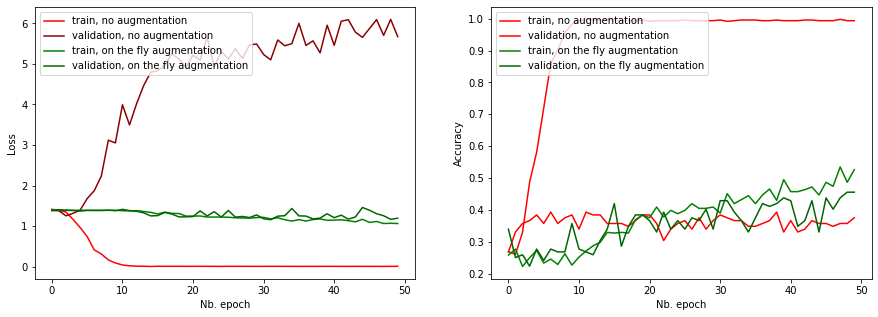

In [20]:

#Light color for train and dark for validation
#Green for augmentation and red for no augmentation

fig, axes = plt.subplots(1, 2, figsize=(15,5), sharex=False)


axes[0].plot(history_no_aug.history['loss'], label='train, no augmentation ',color = 'red')
axes[0].plot(history_no_aug.history['val_loss'], label='validation, no augmentation',color = 'darkred')
axes[0].plot(history_aug.history['loss'], label='train, on the fly augmentation ', color='green')
axes[0].plot(history_aug.history['val_loss'], label='validation, on the fly augmentation', color='darkgreen')

axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Nb. epoch')
#axes[0].title('Loss for 4 species of dogs without data augmentation')
axes[0].legend(loc='upper left')


axes[1].plot(history_no_aug.history['accuracy'], label='train, no augmentation ',color = 'red')
axes[1].plot(history_no_aug.history['val_accuracy'], label='validation, no augmentation',color = 'red')


axes[1].plot(history_aug.history['accuracy'], label='train, on the fly augmentation ', color='green')
axes[1].plot(history_aug.history['val_accuracy'], label='validation, on the fly augmentation', color='darkgreen')

axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Nb. epoch')
#axes[1].title('Accuracy for 4 species of dogs without data augmentation')
axes[1].legend(loc='upper left')

plt.savefig(root_dir+'pngs/train_aug_no_aug.png')
plt.show()

## Lets do some transfert learning

In [15]:
base_model_VGG19 = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=input_shape, classes=len(baseline_species))


80142336/80134624 [==============================] - 1s 0us/step


In [16]:
model_vgg19 = create_cnn(input_shape=input_shape, output_length=len(baseline_species),
               nb_cnn=3, nb_filters = 64, activation_cnn = 'relu', 
               model_transfert = base_model_VGG19, fine_tune = False, 
               nb_FC_layer = 3, nb_FC_neurons = 512, reducing = True, activation_FC = 'relu',
               dropout = False
               )

model_vgg19.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_vgg19.summary()

Model: "my_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
FC_layer_1 (Dense)           (None, 512)               4194816   
_________________________________________________________________
FC_layer_2 (Dense)           (None, 256)               131328    
_________________________________________________________________
FC_layer_3 (Dense)           (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 24,383,940
Trainable params: 4,359,556
Non-trainable params: 20,024,384
__________________________________

In [17]:
#Define the optimizer 
learn_rate=.001
sgd=tf.keras.optimizers.SGD(lr=learn_rate,momentum=.9,nesterov=False)

### Everything is ready, lets compare models training with and without data augmentation : 
* Using no data augmentation
* Using on the fly data augmentation

In [18]:
history_no_aug = model_vgg19.fit_generator(generator=train_generator_no_aug,
                                  steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=validation_generator,
                        validation_steps=STEP_SIZE_VALID,
                        epochs=100,
                        #callbacks=get_callbacks()
                        )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
30/30 [==============================] - 131s 4s/step - loss: 1.7354 - accuracy: 0.3225 - val_loss: 1.5168 - val_accuracy: 0.3661
Epoch 2/100
30/30 [==============================] - 3s 107ms/step - loss: 0.9347 - accuracy: 0.5923 - val_loss: 1.6151 - val_accuracy: 0.5000
Epoch 3/100
30/30 [==============================] - 3s 105ms/step - loss: 0.6694 - accuracy: 0.6961 - val_loss: 0.9431 - val_accuracy: 0.5625
Epoch 4/100
30/30 [==============================] - 3s 108ms/step - loss: 0.3304 - accuracy: 0.8808 - val_loss: 0.9567 - val_accuracy: 0.5982
Epoch 5/100
30/30 [==============================] - 3s 107ms/step - loss: 0.2361 - accuracy: 0.9052 - val_loss: 1.0227 - val_accuracy: 0.6339
Epoch 6/100
30/30 [==============================] - 3s 106ms/step - loss: 0.1147 - accuracy: 0.9600 - val_loss: 1.2493 - val_accuracy: 0.5268
Epoch 7/100
30/30 [==============================] - 3s 106ms/step - loss: 0.0474 - accuracy: 0.9947 - val_loss: 1.2102 - val_accuracy: 0.5714


In [28]:
# re-initialize the same model 
model_vgg19 = create_cnn(input_shape=input_shape, output_length=len(baseline_species),
               nb_cnn=3, nb_filters = 64, activation_cnn = 'relu', 
               model_transfert = base_model_VGG19, fine_tune = False, 
               nb_FC_layer = 3, nb_FC_neurons = 512, reducing = True, activation_FC = 'relu',
               dropout = False
               )

model_vgg19.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_vgg19.summary()

Model: "my_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
FC_layer_1 (Dense)           (None, 512)               4194816   
_________________________________________________________________
FC_layer_2 (Dense)           (None, 256)               131328    
_________________________________________________________________
FC_layer_3 (Dense)           (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 24,383,940
Trainable params: 4,359,556
Non-trainable params: 20,024,384
__________________________________

In [31]:
history_aug_bis = model_vgg19.fit_generator(generator=train_generator,
                                  steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=validation_generator,
                        validation_steps=STEP_SIZE_VALID,
                        epochs=250,
                        #callbacks=get_callbacks()
                        )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/250
30/30 [==============================] - 5s 183ms/step - loss: 0.1779 - accuracy: 0.9224 - val_loss: 1.8572 - val_accuracy: 0.6696
Epoch 2/250
30/30 [==============================] - 5s 175ms/step - loss: 0.1588 - accuracy: 0.9434 - val_loss: 1.5927 - val_accuracy: 0.6964
Epoch 3/250
30/30 [==============================] - 5s 174ms/step - loss: 0.2174 - accuracy: 0.9057 - val_loss: 2.1749 - val_accuracy: 0.5714
Epoch 4/250
30/30 [==============================] - 5s 177ms/step - loss: 0.2921 - accuracy: 0.9057 - val_loss: 1.7694 - val_accuracy: 0.6518
Epoch 5/250
30/30 [==============================] - 5s 174ms/step - loss: 0.2058 - accuracy: 0.9140 - val_loss: 1.3480 - val_accuracy: 0.6786
Epoch 6/250
30/30 [==============================] - 5s 176ms/step - loss: 0.1990 - accuracy: 0.9224 - val_loss: 1.7805 - val_accuracy: 0.6339
Epoch 7/250
30/30 [==============================] - 5s 176ms/step - loss: 0.1953 - accuracy: 0.9140 - val_loss: 1.6305 - val_accuracy: 0.6607

In [35]:
model_vgg19.save(root_dir+'models/vgg19.h5')

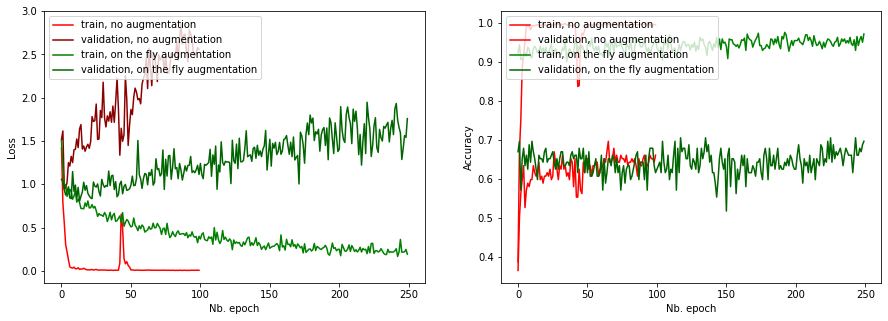

In [45]:
#Light color for train and dark for validation
#Green for augmentation and red for no augmentation

fig, axes = plt.subplots(1, 2, figsize=(15,5), sharex=False)


axes[0].plot(history_no_aug.history['loss'], label='train, no augmentation ',color = 'red')
axes[0].plot(history_no_aug.history['val_loss'], label='validation, no augmentation',color = 'darkred')
axes[0].plot(history_aug.history['loss'], label='train, on the fly augmentation ', color='green')
axes[0].plot(history_aug.history['val_loss'], label='validation, on the fly augmentation', color='darkgreen')

axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Nb. epoch')
#axes[0].title('Loss for 4 species of dogs without data augmentation')
axes[0].legend(loc='upper left')


axes[1].plot(history_no_aug.history['accuracy'], label='train, no augmentation ',color = 'red')
axes[1].plot(history_no_aug.history['val_accuracy'], label='validation, no augmentation',color = 'red')


axes[1].plot(history_aug_bis.history['accuracy'], label='train, on the fly augmentation ', color='green')
axes[1].plot(history_aug_bis.history['val_accuracy'], label='validation, on the fly augmentation', color='darkgreen')

axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Nb. epoch')
#axes[1].title('Accuracy for 4 species of dogs without data augmentation')
axes[1].legend(loc='upper left')

plt.savefig(root_dir+'pngs/train_vgg_aug_no_aug.png')
plt.show()

In [43]:
len(history_aug.history['accuracy']),len(history_aug.history['accuracy'])+len(history_aug_bis.history['accuracy'])

(250, 500)

In [39]:
history = history_aug+history_aug_bis

TypeError: ignored